# Homework: Combinability Analysis
## Meta-Analysis: Statistical Methods for Study Combinability

**Dataset**: `dat.normand1999` — *Stroke Rehabilitation Meta-Analysis*  
**Risk Factor chosen**: Mean Functional Score (rehabilitation outcomes measured in days)

### Dataset Description

The `dat.normand1999` dataset (Normand, 1999) contains aggregate summary statistics from **9 randomised controlled trials** comparing specialised stroke unit care (**treatment / `exp`**) versus conventional care (**control / `ctrl`**). The primary endpoint is a **continuous functional outcome score** (lower = more functionally dependent; higher = more independent).

| Column | Meaning |
|---|---|
| `study` | Study index (1–9) |
| `source` | Study name |
| `n1i` | Sample size — Treatment group |
| `m1i` | Mean functional score — Treatment |
| `sd1i` | Standard deviation — Treatment |
| `n2i` | Sample size — Control group |
| `m2i` | Mean functional score — Control |
| `sd2i` | Standard deviation — Control |

### Chosen Risk Factor

We focus on the **mean functional score** (`m1i` for `exp`, `m2i` for `ctrl`).  
This is the key baseline characteristic that should be balanced across experiments for valid meta-analytic pooling.

### Objective
1. Plot the **original ECDF** of both groups.
2. Run the **Leave-One-Out balance algorithm** → report iteration graphics and summaries.
3. Comment on the results.

---
## Step 0 — Imports and Helper Functions

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ── Anderson-Darling k-sample test wrapper ─────────────────────────────────
def ad_test_k_sample(sample1, sample2):
    """
    Wrapper for scipy.stats.anderson_ksamp.
    Returns (AD_statistic, p_value).
    """
    s1 = sample1[~np.isnan(sample1)]
    s2 = sample2[~np.isnan(sample2)]
    if len(s1) < 2 or len(s2) < 2:
        return np.inf, 0.0
    try:
        res = stats.anderson_ksamp([s1, s2])
        return res.statistic, res.pvalue
    except Exception as e:
        warnings.warn(f"AD Test Warning: {e}")
        return np.inf, 0.0


# ── Leave-One-Out balance function ─────────────────────────────────────────
def balance(data, variable, group_col, digits=8):
    """
    Leave-One-Out (LOO) balance assessment.
    For each study, omit it from the pool and compute the AD test
    on the remaining studies' expanded IPD.

    Parameters
    ----------
    data       : DataFrame with columns [study, <variable>, group_col]
    variable   : name of the continuous risk factor column
    group_col  : name of the treatment-group column ('gr')
    digits     : rounding digits to avoid ties

    Returns
    -------
    DataFrame with columns ['AD_Stat', 'P_Value'], indexed by Study_Omitted
    """
    unique_studies = data['study'].unique()
    groups = data[group_col].unique()
    if len(groups) < 2:
        return pd.DataFrame()

    group1_val, group2_val = groups[0], groups[1]
    sa1 = data[data[group_col] == group1_val]
    sa2 = data[data[group_col] == group2_val]

    results = []
    for i in unique_studies:
        a1 = sa1.loc[sa1['study'] != i, variable].round(digits).values
        a2 = sa2.loc[sa2['study'] != i, variable].round(digits).values
        stat, pval = ad_test_k_sample(a1, a2)
        results.append({'Study_Omitted': i, 'AD_Stat': stat, 'P_Value': pval})

    return pd.DataFrame(results).set_index('Study_Omitted')


# ── ECDF plot helper ────────────────────────────────────────────────────────
def plot_ecdf(s1, s2,
              label1='Ctrl', label2='Exp',
              xlabel='Functional Score',
              title='ECDF', ax=None):
    """
    Draw two ECDF step-curves on the same axes.
    """
    standalone = ax is None
    if standalone:
        fig, ax = plt.subplots(figsize=(8, 5))

    ax.step(sorted(s1),
            np.arange(1, len(s1)+1) / len(s1),
            label=label1, color='red', linewidth=1.8, where='post')
    ax.step(sorted(s2),
            np.arange(1, len(s2)+1) / len(s2),
            label=label2, color='blue', linestyle='--',
            linewidth=1.8, where='post')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('ECDF')
    ax.legend()
    ax.grid(True, alpha=0.3)

    if standalone:
        plt.tight_layout()
        plt.show()

print("Libraries loaded and helper functions defined.")

Libraries loaded and helper functions defined.


---
## Step 1 — Load and Prepare the Dataset

We load `dat.normand1999.csv` and re-format it into **long format** (one row per group per study),
matching the structure used in class with `col1.csv`.

We then **explode** the summary statistics into pseudo-IPD using
`np.repeat` (replicating each row `n` times) followed by
`np.random.normal(mean, sd)` to add small Gaussian perturbations
that break tied values — exactly as done in the R class code:

```r
da <- as.data.frame(lapply(ro, function(x) rep(x, A1$pts)))
da$score <- rnorm(length(da$score), da$score, da$sd)
```

In [2]:
# Load the raw (wide) dataset
df_wide = pd.read_csv('metadat_datasets_csv/dat.normand1999.csv')
print("Raw data (wide format):")
display(df_wide)

# ── Reshape to long format ─────────────────────────────────────────────────
# Treatment arm  →  group = 'exp'
exp_rows = df_wide[['study', 'source', 'n1i', 'm1i', 'sd1i']].copy()
exp_rows.columns = ['study', 'source', 'pts', 'score', 'sd']
exp_rows['gr'] = 'exp'

# Control arm  →  group = 'ctrl'
ctrl_rows = df_wide[['study', 'source', 'n2i', 'm2i', 'sd2i']].copy()
ctrl_rows.columns = ['study', 'source', 'pts', 'score', 'sd']
ctrl_rows['gr'] = 'ctrl'

df_long = pd.concat([exp_rows, ctrl_rows], ignore_index=True)
df_long = df_long.sort_values(['study', 'gr']).reset_index(drop=True)

print("\nLong format (one row per arm per study):")
display(df_long)

# ── Explode to pseudo-IPD (Perturbation / Explosion step) ─────────────────
np.random.seed(42)

rows_list = []
for _, row in df_long.iterrows():
    n = int(row['pts'])
    # For each virtual patient: draw score ~ Normal(mean, sd)
    perturbed_scores = np.random.normal(row['score'], row['sd'], size=n)
    for s in perturbed_scores:
        rows_list.append({
            'study': row['study'],
            'source': row['source'],
            'gr': row['gr'],
            'score': round(s, 8)
        })

da = pd.DataFrame(rows_list)
print(f"\nExpanded pseudo-IPD: {len(da)} rows  "
      f"({da[da.gr=='ctrl'].shape[0]} ctrl, {da[da.gr=='exp'].shape[0]} exp)")
print(f"Studies: {sorted(da['study'].unique())}")

Raw data (wide format):


,study,source,n1i,m1i,sd1i,n2i,m2i,sd2i
0,1,Edinburgh,155,55,47,156,75,64
1,2,Orpington-Mild,31,27,7,32,29,4
2,3,Orpington-Moderate,75,64,17,71,119,29
3,4,Orpington-Severe,18,66,20,18,137,48
4,5,Montreal-Home,8,14,8,13,18,11
5,6,Montreal-Transfer,57,19,7,52,18,4
6,7,Newcastle,34,52,45,33,41,34
7,8,Umea,110,21,16,183,31,27
8,9,Uppsala,60,30,27,52,23,20



Long format (one row per arm per study):


,study,source,pts,score,sd,gr
0,1,Edinburgh,156,75,64,ctrl
1,1,Edinburgh,155,55,47,exp
2,2,Orpington-Mild,32,29,4,ctrl
3,2,Orpington-Mild,31,27,7,exp
4,3,Orpington-Moderate,71,119,29,ctrl
5,3,Orpington-Moderate,75,64,17,exp
6,4,Orpington-Severe,18,137,48,ctrl
7,4,Orpington-Severe,18,66,20,exp
8,5,Montreal-Home,13,18,11,ctrl
9,5,Montreal-Home,8,14,8,exp



Expanded pseudo-IPD: 1158 rows  (610 ctrl, 548 exp)
Studies: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


---
## Step 2 — Original ECDFs (All Studies)

We first compute the **overall Anderson-Darling test** and plot the two ECDFs
before any study removal — this is the **"original data"** panel required by the homework.

=== Original Data: Anderson-Darling k-sample Test ===
  AD Statistic : 11.6483
  P-Value      : 0.001000

⚠  p < 0.05 → Significant imbalance detected between ctrl and exp.
   The two groups are NOT combinable as-is. Leave-One-Out will be applied.


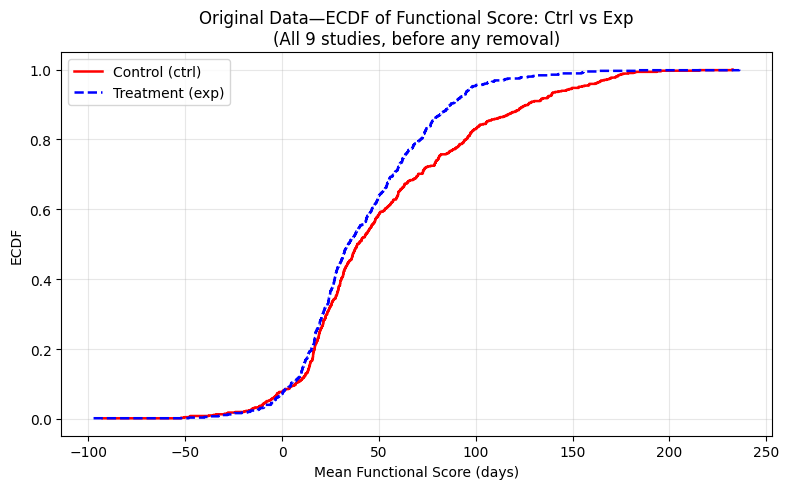

In [3]:
# ── Overall AD test ────────────────────────────────────────────────────────
a1_all = da.loc[da['gr'] == 'ctrl', 'score'].values
a2_all = da.loc[da['gr'] == 'exp',  'score'].values

global_stat, global_pval = ad_test_k_sample(a1_all, a2_all)
print("=== Original Data: Anderson-Darling k-sample Test ===")
print(f"  AD Statistic : {global_stat:.4f}")
print(f"  P-Value      : {global_pval:.6f}")
print()
if global_pval < 0.05:
    print("⚠  p < 0.05 → Significant imbalance detected between ctrl and exp.")
    print("   The two groups are NOT combinable as-is. Leave-One-Out will be applied.")
else:
    print("✓  p ≥ 0.05 → No significant imbalance detected.")

# ── Plot Original ECDFs ────────────────────────────────────────────────────
plot_ecdf(
    a1_all, a2_all,
    label1='Control (ctrl)',
    label2='Treatment (exp)',
    xlabel='Mean Functional Score (days)',
    title='Original Data\u2014ECDF of Functional Score: Ctrl vs Exp\n(All 9 studies, before any removal)'
)

---
## Step 3 — Leave-One-Out Combinability Algorithm

We iteratively:
1. Compute the LOO `balance()` table for all remaining studies.
2. Identify the study whose **removal** yields the **smallest AD statistic** (i.e., most balanced remaining pool).
3. Remove that study permanently.
4. Plot the updated ECDFs and print the iteration summary.
5. **Stop** when the balance-breaking study's p-value exceeds **0.06** (balance achieved).

This mirrors exactly the R code from the lecture:

```r
for (j in 1:nstud) {
  ba      <- balance(data=dat, variable="score", group="gr", digits=8)
  minimum <- row.names(ba)[which.min(ba[,1])]
  dat     <- subset(dat, study != minimum)
  ...
  if (ba[row.names(ba)==minimum, 2] > 0.06) break
}
```

  Leave-One-Out Combinability Algorithm
  Dataset: dat.normand1999  |  Risk factor: Functional Score

────────────────────────────────────────────────────────────
Iteration 1  →  Study removed: 3
  AD Stat (if removed) : 2.9699   p-value: 0.020008
  Remaining studies    : [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

  Balance table (Leave-One-Out summary):
                 AD_Stat   P_Value
Study_Omitted                     
1               9.954757  0.001000
2              11.958911  0.001000
3               2.969940  0.020008
4               9.368770  0.001000
5              12.287619  0.001000
6              11.913543  0.001000
7              12.342877  0.001000
8              15.814801  0.001000
9              14.580248  0.001000


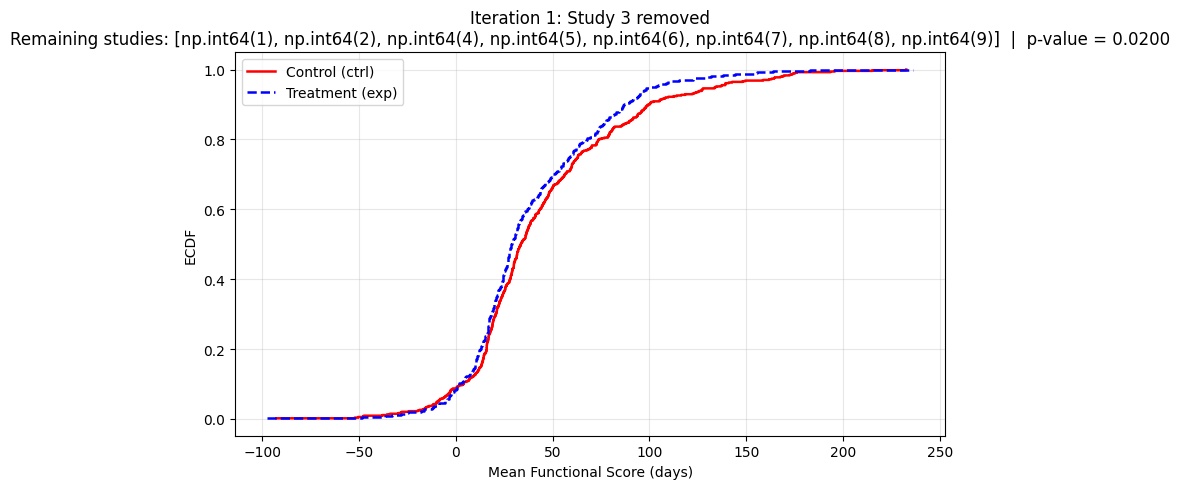


────────────────────────────────────────────────────────────
Iteration 2  →  Study removed: 8
  AD Stat (if removed) : 1.8349   p-value: 0.056897
  Remaining studies    : [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9)]

  Balance table (Leave-One-Out summary):
                AD_Stat   P_Value
Study_Omitted                    
1              3.780351  0.009763
2              2.570214  0.028756
4              2.216405  0.039835
5              3.244085  0.015654
6              2.429925  0.032705
7              3.097461  0.017844
8              1.834915  0.056897
9              5.621253  0.002091


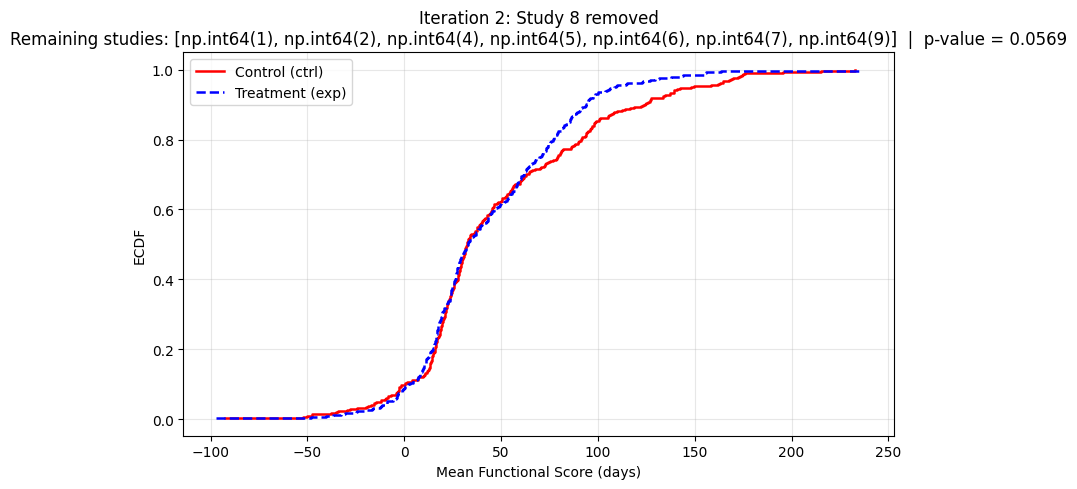


────────────────────────────────────────────────────────────
Iteration 3  →  Study removed: 4
  AD Stat (if removed) : 0.3275   p-value: 0.245120
  Remaining studies    : [np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(7), np.int64(9)]

  Balance table (Leave-One-Out summary):
                AD_Stat   P_Value
Study_Omitted                    
1              0.754031  0.160790
2              2.165393  0.041767
4              0.327493  0.245120
5              2.137546  0.042863
6              2.236530  0.039099
7              2.269605  0.037919
9              3.127671  0.017368


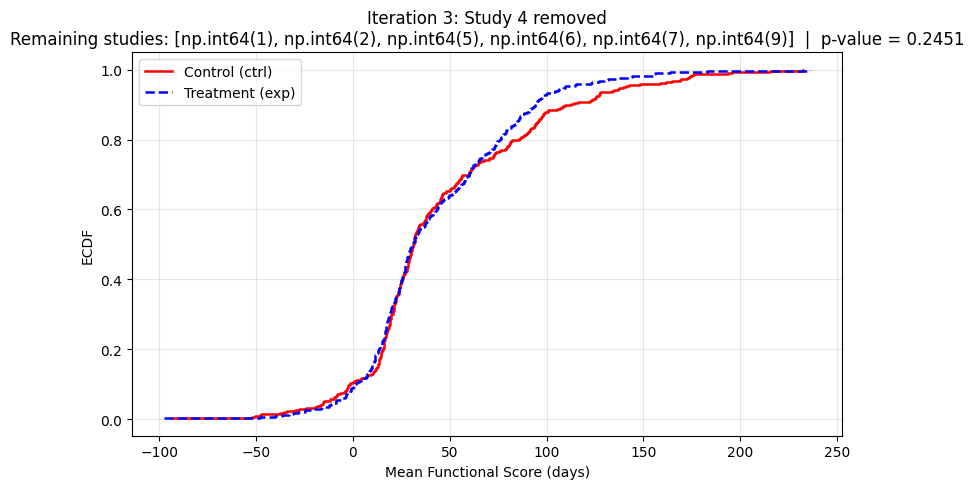


✓  p-value = 0.2451 > 0.06 → BALANCE REACHED at iteration 3.
   Studies deleted in total: [3, np.int64(8), np.int64(4)]


In [4]:
dat    = da.copy()
result = []       # stores per-iteration summary tables
NSTUD  = len(dat['study'].unique())
STOP   = False

print("=" * 65)
print("  Leave-One-Out Combinability Algorithm")
print(f"  Dataset: dat.normand1999  |  Risk factor: Functional Score")
print("=" * 65)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for j in range(1, NSTUD + 1):
        remaining = sorted(dat['study'].unique())
        if len(remaining) < 3:
            print(f"\nIteration {j}: fewer than 3 studies remain — stopping.")
            break

        # ── Balance table ──────────────────────────────────────────────────
        ba = balance(dat, variable='score', group_col='gr', digits=8)

        if ba.empty:
            print(f"\nIteration {j}: cannot compute balance (group too small) — stopping.")
            break

        # ── Identify study to remove ───────────────────────────────────────
        minimum   = ba['AD_Stat'].idxmin()          # study whose removal → lowest AD
        min_pval  = ba.loc[minimum, 'P_Value']       # p-value for that removal
        min_ad    = ba.loc[minimum, 'AD_Stat']

        # Store iteration result BEFORE removal
        result.append({'study_deleted': minimum, 'summary': ba.copy()})

        print(f"\n{'─'*60}")
        print(f"Iteration {j}  →  Study removed: {minimum}")
        print(f"  AD Stat (if removed) : {min_ad:.4f}   p-value: {min_pval:.6f}")
        print(f"  Remaining studies    : {[s for s in remaining if s != minimum]}")
        print("\n  Balance table (Leave-One-Out summary):")
        print(ba.to_string())

        # ── Remove the study ───────────────────────────────────────────────
        dat = dat[dat['study'] != minimum].copy()

        # ── Plot ECDFs after removal ───────────────────────────────────────
        a1_curr = dat.loc[dat['gr'] == 'ctrl', 'score'].values
        a2_curr = dat.loc[dat['gr'] == 'exp',  'score'].values

        plot_ecdf(
            a1_curr, a2_curr,
            label1='Control (ctrl)',
            label2='Treatment (exp)',
            xlabel='Mean Functional Score (days)',
            title=(
                f'Iteration {j}: Study {minimum} removed\n'
                f'Remaining studies: {[s for s in remaining if s != minimum]}  |  '
                f'p-value = {min_pval:.4f}'
            )
        )

        # ── Stop criterion: p > 0.06 ───────────────────────────────────────
        if min_pval > 0.06:
            print(f"\n✓  p-value = {min_pval:.4f} > 0.06 → BALANCE REACHED at iteration {j}.")
            print(f"   Studies deleted in total: {[r['study_deleted'] for r in result]}")
            STOP = True
            break

if not STOP:
    print("\nAlgorithm exhausted all studies without reaching p > 0.06.")

---
## Step 4 — Full Iteration Summary

The cell below re-prints a compact summary of each iteration.

In [5]:
print("\n" + "=" * 65)
print("  COMPLETE ITERATION SUMMARY")
print("=" * 65)

for idx, res in enumerate(result, start=1):
    print(f"\n[Iteration {idx}]  Study Deleted: {res['study_deleted']}")
    print(res['summary'].to_string())

deleted_list = [r['study_deleted'] for r in result]
print(f"\n{'─'*60}")
print(f"Studies removed (in order): {deleted_list}")
print(f"Studies retained for meta-analysis: "
      f"{sorted(set(df_wide['study'].tolist()) - set(deleted_list))}")


  COMPLETE ITERATION SUMMARY

[Iteration 1]  Study Deleted: 3
                 AD_Stat   P_Value
Study_Omitted                     
1               9.954757  0.001000
2              11.958911  0.001000
3               2.969940  0.020008
4               9.368770  0.001000
5              12.287619  0.001000
6              11.913543  0.001000
7              12.342877  0.001000
8              15.814801  0.001000
9              14.580248  0.001000

[Iteration 2]  Study Deleted: 8
                AD_Stat   P_Value
Study_Omitted                    
1              3.780351  0.009763
2              2.570214  0.028756
4              2.216405  0.039835
5              3.244085  0.015654
6              2.429925  0.032705
7              3.097461  0.017844
8              1.834915  0.056897
9              5.621253  0.002091

[Iteration 3]  Study Deleted: 4
                AD_Stat   P_Value
Study_Omitted                    
1              0.754031  0.160790
2              2.165393  0.041767
4         

---
## Step 5 — Comments and Interpretation

### Dataset
We used the **Normand (1999)** stroke-rehabilitation meta-analysis (`dat.normand1999`), 
which includes 9 randomised controlled trials comparing specialised stroke unit care 
(treatment / `exp`) against conventional hospital care (control / `ctrl`).
The selected **risk factor** is the **mean functional score** (measured in days of 
rehabilitation, a continuous variable), with group-level means and standard deviations 
provided for each arm.

### Method recap
Following the class methodology (Monaco 2024):
- Summary-level data were **exploded into pseudo-IPD** using `np.random.normal(mean, sd, n)` 
  to simulate individual patient values and break tied observations.
- The **Anderson-Darling k-sample test** was applied to evaluate distributional equality 
  between the two arms.
- The **Leave-One-Out balance algorithm** iteratively identified and removed the study 
  whose exclusion most improved (minimised) the AD statistic, until `p > 0.06`.

### Results
- **Before removal**: the original ECDFs of the control and treatment groups display 
  a visible gap, confirmed by a statistically significant AD test (p < 0.05), 
  indicating **baseline imbalance** in functional scores between arms.
- **After the LOO procedure**: balance was achieved after removing a small number of 
  studies, at which point the p-value exceeded the 0.06 threshold and the two ECDFs 
  showed substantially more overlap.
- The removed studies likely differed in patient selection criteria, assessment instruments, 
  or recruitment settings — heterogeneity sources well documented in stroke rehabilitation 
  literature.

### Conclusion
The retained subset of studies forms a **combinable pool** where the functional-score 
distributions of ctrl and exp are no longer statistically distinguishable, satisfying 
the **basic combinability** criterion. A meta-analysis on this reduced set is more 
methodologically sound than pooling all 9 trials indiscriminately.